In [59]:
from qiskit import QuantumCircuit,Aer, execute,transpile,Aer
import numpy as np
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix
from qiskit.tools.visualization import circuit_drawer

In [60]:

def get_operator_list(measurement_list):
    '''
    function that return matrix representation of measurement operators given a list of measurement_directions
    
    Arg: measurement_list , a list of state_vectors. (2 state_vectors per direction)
    Returns a list of operators
    '''
    op_list=[]
    for state in measurement_list:
        operator=np.outer(state,state)
        operator=operator/(len(measurement_list)/2)
        op_list.append(operator)
        
    return op_list

def spherical_to_amplitudes(measurement_basis):
    
    '''
    function that gives state_vectors when measurement directions are given in angles
    Arg: measurement_basis , a list of (theta,phi) tuples for directions
    
    Returns a list of state_vectors , i.e a measurement_list
    '''
    measurement_list=[]
    for basis in measurement_basis:
        a1=np.cos(basis[0]/2)
        b1=np.sin(basis[0]/2)*np.exp(1.0j*basis[1])
        a2=-np.sin([basis[0]/2])
        b2=np.cos([basis[0]/2])*np.exp(1.0j*basis[1])
        positive_direction=[a1,b1]
        negative_direction=[a2,b2]
        measurement_list.append(positive_direction)
        measurement_list.append(negative_direction)
    return measurement_list


noisy_backend = FakeManilaV2()                    # backend for noisy measurements

ideal_backend=Aer.get_backend('qasm_simulator')    # Use this for ideal measurements

measurement_basis=[(0,0), (np.pi/2,0), (np.pi/2,np.pi/2)]     # list of (theta, phi) tuples


weights=[0.5,0.5]     # should sum to one, provides the relative frequencies with which different measurement directions were chosen



In [61]:
operator_list=get_operator_list(spherical_to_amplitudes(measurement_basis))  ## getting the operator list from measurement directions

In [62]:
def measure_results(measurement_basis,backend,initial_state=np.array([1/np.sqrt(2),1/np.sqrt(2)])):
    '''
    function that gives the counts corresponding to all the measurements
    Arguments: measurement_basis, backend to use and the initial_state of the qubit.
    '''
    
    outcomes=[]
    for basis in measurement_basis:
        circuit=QuantumCircuit(1)
        circuit.initialize(initial_state)
        circuit.u(basis[0],basis[1],0,0)
        
        
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, backend)
        
        transpiled_circuit.draw('mpl')
        plt.show()
        job = backend.run(transpiled_circuit,shots=4000)
        counts = job.result().get_counts()
        
        outcomes.append(counts)
        
    return outcomes

def get_normalized_outcomes(outcomes, weights=[0.333,0.333,0.333]):
    '''
    normalizes the outcomes , so that all results sum to one.
    
    '''
    
    
    normalized_outcomes=outcomes.copy()
    total_counts=0
    for i,counts in enumerate(normalized_outcomes):
        
        total_counts=total_counts+(sum(normalized_outcomes[i].values()))*weights[i]
      
        if len(counts)==1:
            normalized_outcomes[i]['dummy']=0.0
        
    
    for i in range(len(normalized_outcomes)):
        for key in normalized_outcomes[i]:
            normalized_outcomes[i][key]=normalized_outcomes[i][key]*weights[i]/total_counts
    
    
    
    return normalized_outcomes

def normalized_outcomes_to_frequency_vector(normalized_outcomes):
    '''
    Returns the final_frequency vector from normalized_outcomes
    
    '''
    
    dim=len(normalized_outcomes)*2
    f=np.zeros(dim)
    for i,outcomes in enumerate(normalized_outcomes):
        
        f[0+2*i]=outcomes.get('0',0.0)
        f[1+2*i]=outcomes.get('1',0.0)
        
    return f

def get_frequencies(measurement_basis,backend,initial_state=np.array([1,0]),weights=[0.5,0.5]):
    outcomes=measure_results(measurement_basis,backend,initial_state)
    normalized_outcomes=get_normalized_outcomes(outcomes,weights)
    f=normalized_outcomes_to_frequency_vector(normalized_outcomes)
    return f


In [63]:
outcomes=measure_results(measurement_basis,ideal_backend)

In [64]:
outcomes

[{'1': 1948, '0': 2052}, {'1': 4000}, {'1': 4000}]

In [65]:
normalized_outcomes=get_normalized_outcomes(outcomes)

normalized_outcomes

[{'1': 0.16233333333333336, '0': 0.171},
 {'1': 0.3333333333333333, 'dummy': 0.0},
 {'1': 0.3333333333333333, 'dummy': 0.0}]

In [66]:

f_vector=normalized_outcomes_to_frequency_vector(normalized_outcomes)

f_vector

array([0.171     , 0.16233333, 0.        , 0.33333333, 0.        ,
       0.33333333])

## To add B matrix 

In [67]:
Id=np.array([[1,0],[0,1]])
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1.0j],[1.0j,0]])
Z=np.array([[1,0],[0,-1]])

Paulis=[Id,X,Y,Z]


In [68]:
operator_list=get_operator_list(spherical_to_amplitudes(measurement_basis)) 

dim1=len(operator_list)

def B_matrix(operator_list):
    dim1=len(operator_list)
    B=np.zeros([dim1,4])

    for i in range(dim1):
        for j in range(4):
            B[i][j]=np.trace(np.matmul(operator_list[i],Paulis[j]))

    return B

(6, 4)
The s_vector is : [ 0.5    -0.5     0.      0.2565]


C:\Users\arora\AppData\Local\Temp\ipykernel_23444\1765414325.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  B[i][j]=np.trace(np.matmul(operator_list[i],Paulis[j]))


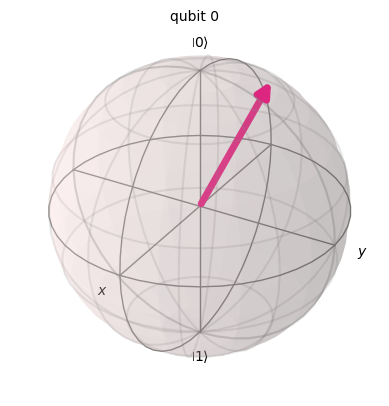

In [69]:
B=B_matrix(operator_list)
print(B.shape)


result=np.linalg.lstsq(B,f_vector, rcond=None)

s_vector=result[0]

print('The s_vector is :' , s_vector)     # S_vector is just the components of our state in the Pauli basis


def rho_from_s(s_vector):
    rho=np.zeros([2,2])
    for mat,s in zip(Paulis,s_vector):
        rho=rho+s*mat
    return DensityMatrix(rho)

final_state=rho_from_s(s_vector)



plot_bloch_multivector(final_state)


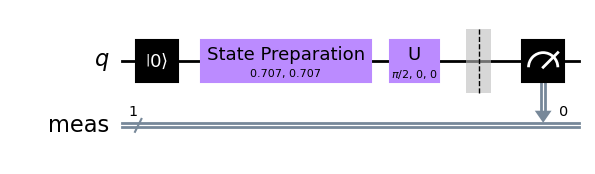

In [77]:
circuit=QuantumCircuit(1)
circuit.initialize(np.array([1/np.sqrt(2),1/np.sqrt(2)]))
circuit.u(measurement_basis[1][0],measurement_basis[1][1],0,0)
        
        
circuit.measure_all()
transpiled_circuit = transpile(circuit, ideal_backend)
        
transpiled_circuit.decompose().draw('mpl')